In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_id = '1AVbnOfblP2lJTOowA1JFTZ-wS-wYc6b3'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':'1AVbnOfblP2lJTOowA1JFTZ-wS-wYc6b3'}) # replace the id with id of file you want to access
downloaded.GetContentFile('cherat-final-dataset.csv')  
 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls
%pwd
%cd /content
%ls

adc.json  cherat-final-dataset.csv  drive/  sample_data/
/content
adc.json  cherat-final-dataset.csv  drive/  sample_data/


In [ ]:
%cd drive/

/content/drive


In [ ]:
%cd MyDrive/

/content/drive/MyDrive


In [ ]:
%cd tensorboard/
%cd model/
%ls

/content/drive/MyDrive/tensorboard
/content/drive/MyDrive/tensorboard/model
 cherat-final-dataset.csv
 cherat_nn_model1.pt
 cherat_nn_model2.pt
 cherat_nn_model.pt
'copy1 of steel_nn_model-30neurons- 900 epochs - lr0.001.pt'
'copy of steel_nn_model-30neurons- 900 epochs - lr0.001.pt'
'copy of steel_nn_model.pt'
'final-copy1 of steel_nn_model-30neurons- 900 epochs - lr0.001.pt'
 internationalsteels-final-dataset.csv
 ogdc.csv
 ogdc_nn_model-final.pt
 ogdc_nn_model.pt
 runs/
 steel_nn_model.pt


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt


import statsmodels.graphics.tsaplots as sgt
#from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

import seaborn as sns
import statsmodels.tsa.stattools as sts


from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse    
from statsmodels.tools.eval_measures import mse   
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable   # A Variable wraps a Tensor. It supports nearly all the API’s defined by a Tensor. Variable also provides a backward method to perform backpropagation. For example, to backpropagate a loss function to train model parameter x, we use a variable loss to store the value computed by a loss function. Then, we call loss.backward which computes the gradients ∂loss∂x for all trainable parameters. PyTorch will store the gradient results back in the corresponding variable x.
%matplotlib inline


import warnings 
warnings.filterwarnings ("ignore")


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df1 = pd.read_csv('cherat-final-dataset.csv')

# Preprocessing #

In [ ]:
def preprocessing(dataframe):
    df = dataframe.iloc[::-1]
    #df = df.drop(['Price', 'High', 'Low'], axis=1)
    df['Date']= pd.to_datetime(df['Date'], format= '%d/%m/%Y')  # datetime conversion.........
    df.set_index("Date", inplace= True) # created date as an index
    return df

In [ ]:
preprocessed_df = preprocessing(df1)

In [ ]:
columns_names = ['Net_Margin', 'ROE', 'Quick_Ratio', 'Current_Ratio',
       'Assets_Equity', 'Debt_Equity', 'A_RTurnover', 'AvgA_RDays',
       'InvTurnover', 'EBITDATotAssetsTTM', 'ROATotAssets', 'HistMktCap',
       'HistEV', 'GDPExports', 'Inflationgdp', 'moneysupply',
       'treasures_bill', 'DollarRate_Open']

interpolate_df = []
for i in columns_names:
    a = preprocessed_df[i].interpolate(method='time')
#     plt.scatter(df.index, a,  alpha=0.5, color='red' )
#     plt.scatter(df.index, i,  alpha=0.5, color='blue')
    interpolate_df.append(a)

interpolate_df = pd.DataFrame(interpolate_df).T
df = pd.concat([preprocessed_df.Open, preprocessed_df.Vol,preprocessed_df.High,preprocessed_df.Low,preprocessed_df.Price, interpolate_df], axis = 1)

In [ ]:
df

,Open,Vol,High,Low,Price,Net_Margin,ROE,Quick_Ratio,Current_Ratio,Assets_Equity,Debt_Equity,A_RTurnover,AvgA_RDays,InvTurnover,EBITDATotAssetsTTM,ROATotAssets,HistMktCap,HistEV,GDPExports,Inflationgdp,moneysupply,treasures_bill,DollarRate_Open
Date,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,7.78,690400,8.50,7.50,8.50,0.039000,0.190000,0.150000,1.250000,2.090000,0.780000,25.600000,3.600000,0.700000,0.124300,0.034900,-0.071400,-0.099000,2.595000,20.670000,0.442,11.90,84.450000
2010-02-01,8.56,574600,8.85,7.47,7.67,0.020610,0.091220,0.134237,1.176441,2.095254,0.811525,23.445763,3.915254,0.752542,0.111637,0.029751,0.032897,0.009237,1.838915,19.758563,0.068,12.22,85.200000
2010-03-01,7.48,1490000,7.50,6.28,7.06,0.004000,0.002000,0.120000,1.110000,2.100000,0.840000,21.500000,4.200000,0.800000,0.100200,0.025100,0.127100,0.107000,1.156000,18.935329,2.150,12.34,85.150000
2010-04-01,7.30,1440000,7.63,6.88,7.24,-0.029022,-0.008783,0.103152,1.035870,2.140435,0.890543,19.815217,4.638043,0.732609,0.087362,0.016878,0.024632,0.071855,-4.618087,18.023892,1.783,12.27,84.000000
2010-05-01,7.36,658000,7.48,5.70,5.87,-0.060978,-0.019217,0.086848,0.964130,2.179565,0.939457,18.184783,5.061957,0.667391,0.074938,0.008922,-0.074532,0.037845,-10.205913,17.141856,-1.011,12.09,84.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,57.80,31500000,57.80,49.00,56.95,-0.084923,-0.032505,0.451429,1.255495,2.965934,1.736374,1.568132,56.825275,0.900000,0.105153,0.037725,-0.222818,-0.088673,-7.223484,8.616612,1.155,13.34,160.555041
2020-03-01,58.50,4060000,88.12,43.00,55.59,-0.076000,-0.029000,0.410000,1.230000,2.950000,1.730000,1.600000,55.200000,0.900000,0.103400,0.030300,-0.089800,-0.054000,-7.785000,8.615027,-4.711,11.19,162.180000
2020-04-01,55.26,2110000,98.50,53.31,89.85,-0.065217,-0.025967,0.396522,1.230000,2.960109,1.726630,1.903261,49.033696,0.933696,0.101917,0.021842,0.301272,0.030441,-15.866228,8.613333,5.406,7.88,163.770435


In [ ]:
 df = df.drop(['Net_Margin','Quick_Ratio','Current_Ratio','Assets_Equity','Debt_Equity','A_RTurnover','AvgA_RDays','HistMktCap'], axis=1)

In [ ]:
df.Open.min()

4.42

In [ ]:
df.Open.max()

181.82

# How useful are our features for prediction?

In [ ]:
# Adjusted R-squared is the answer. It tells us how good our features explain the variation in our label

In [ ]:
#create a new dataframe to model the difference
df_diff = df.copy()#add previous sales to the next row
df_diff['prev_Open'] = df_diff['Open'].shift(1)#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['Open'] - df_diff['prev_Open'])
df_diff.head(10)

,Open,Vol,High,Low,Price,Net_Margin,ROE,Quick_Ratio,Current_Ratio,Assets_Equity,Debt_Equity,A_RTurnover,AvgA_RDays,InvTurnover,EBITDATotAssetsTTM,ROATotAssets,HistMktCap,HistEV,GDPExports,Inflationgdp,moneysupply,treasures_bill,DollarRate_Open,prev_Open,diff
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-01,8.56,574600,8.85,7.47,7.67,0.020610,0.091220,0.134237,1.176441,2.095254,0.811525,23.445763,3.915254,0.752542,0.111637,0.029751,0.032897,0.009237,1.838915,19.758563,0.068,12.22,85.20,7.78,0.78
2010-03-01,7.48,1490000,7.50,6.28,7.06,0.004000,0.002000,0.120000,1.110000,2.100000,0.840000,21.500000,4.200000,0.800000,0.100200,0.025100,0.127100,0.107000,1.156000,18.935329,2.150,12.34,85.15,8.56,-1.08
2010-04-01,7.30,1440000,7.63,6.88,7.24,-0.029022,-0.008783,0.103152,1.035870,2.140435,0.890543,19.815217,4.638043,0.732609,0.087362,0.016878,0.024632,0.071855,-4.618087,18.023892,1.783,12.27,84.00,7.48,-0.18
2010-05-01,7.36,658000,7.48,5.70,5.87,-0.060978,-0.019217,0.086848,0.964130,2.179565,0.939457,18.184783,5.061957,0.667391,0.074938,0.008922,-0.074532,0.037845,-10.205913,17.141856,-1.011,12.09,84.00,7.30,0.06
2010-06-01,5.87,1340000,6.79,5.40,5.60,-0.094000,-0.030000,0.070000,0.890000,2.220000,0.990000,16.500000,5.500000,0.600000,0.062100,0.000700,-0.177000,0.002700,-15.980000,16.230419,0.464,12.27,85.10,7.36,-1.49
2010-07-01,5.69,248500,6.58,5.39,5.98,-0.096935,-0.033261,0.066739,0.863913,2.278696,1.012826,29.739130,4.228261,0.632609,0.051828,-0.006604,-0.138783,0.000189,-6.973478,15.348383,0.991,12.33,85.50,5.87,-0.18
2010-08-01,6.43,1160000,7.18,5.33,6.64,-0.099967,-0.036630,0.063370,0.836957,2.339348,1.036413,43.419565,2.914130,0.666304,0.041214,-0.014152,-0.099291,-0.002405,2.333261,14.436946,0.584,12.65,85.20,5.69,0.74
2010-09-01,6.58,413400,7.48,6.10,6.58,-0.103000,-0.040000,0.060000,0.810000,2.400000,1.060000,57.100000,1.600000,0.700000,0.030600,-0.021700,-0.059800,-0.005000,11.640000,13.525509,1.166,12.82,85.40,6.43,0.15
2010-10-01,6.52,1340000,7.43,5.69,7.15,-0.022890,-0.006374,0.063297,0.793516,2.320879,1.033626,58.023077,1.567033,0.700000,0.026248,-0.015502,-0.112152,-0.031374,7.925934,12.643473,1.441,13.08,86.25,6.58,-0.06


In [ ]:
13.# Import statsmodels.formula.api
import statsmodels.formula.api as smf

In [ ]:
# Define the regression formula
model = smf.ols(formula='diff ~  Open + Price + High + Low + Vol + Net_Margin + ROE + Quick_Ratio + Current_Ratio + Assets_Equity + Debt_Equity +  A_RTurnover + AvgA_RDays + InvTurnover + EBITDATotAssetsTTM + ROATotAssets + HistMktCap + HistEV + GDPExports + Inflationgdp + moneysupply + treasures_bill + DollarRate_Open', data=df_diff)

In [ ]:
# Fit the regression
model_fit = model.fit()

In [ ]:
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.15554278794519438


In [ ]:
df_diff.columns.values

array(['Open', 'Vol', 'High', 'Low', 'Price', 'Net_Margin', 'ROE',
       'Quick_Ratio', 'Current_Ratio', 'Assets_Equity', 'Debt_Equity',
       'A_RTurnover', 'AvgA_RDays', 'InvTurnover', 'EBITDATotAssetsTTM',
       'ROATotAssets', 'HistMktCap', 'HistEV', 'GDPExports',
       'Inflationgdp', 'moneysupply', 'treasures_bill', 'DollarRate_Open',
       'prev_Open', 'diff'], dtype=object)

# Splitting Dataset

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# kf = KFold(n_splits=10)
# kf

In [ ]:
# tscv = TimeSeriesSplit(max_train_size=None, n_splits=10)

In [ ]:
# for train_index, test_index in tscv.split(X):

In [ ]:
# for train_index, test_index in kf.split(df):
#   print(train_index, test_index)

In [ ]:
# train_index

In [ ]:
X = df.iloc[:, 0:15] 
y = df.iloc[:, :+1]

# Scaling the Data

In [ ]:
from sklearn.preprocessing import StandardScaler


ss = StandardScaler() ### make the data set normally distributed 


X_ss = ss.fit_transform(X)
y_mm = ss.fit_transform(y) 

In [ ]:
#first 101 for training

X_train = X_ss[:101, :]   ### 101 values
X_test = X_ss[101:, :]    ### 25 values

y_train = y_mm[:101, :]  ### 101 values
y_test = y_mm[101:, :]   ### 25 values

In [ ]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (101, 15) (101, 1)
Testing Shape (25, 15) (25, 1)


In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [ ]:
# Now the next step is to check the input format of an LSTM. This means that since LSTM is specially built for sequential data, it can not take in simple 2-D data as input. They need to have the timestamp information with them too, as we discussed that we need to have input at each timestamp. So let’s convert the dataset.

In [ ]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [ ]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([101, 1, 15]) torch.Size([101, 1])
Testing Shape torch.Size([25, 1, 15]) torch.Size([25, 1])


In [ ]:
# Next we are going to use 2 LSTM layers with the same hyperparameters stacked over each other (via hidden_size), you have defined the 2 Fully Connected layers, the ReLU layer, and some helper variables. Next, you are going to define the forward pass of the LSTM.

In [ ]:
torch.manual_seed(1)

#Final model

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes # 
        self.num_layers = num_layers #number of layers # vertical side 
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state # horizontal side # short term memory 
        self.seq_length = seq_length #sequence length

        
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm    #If our input data is of shape (batch_size, seq_len, features) then you need batch_first=True and your LSTM will give output of shape (batch_size, seq_len, hidden_size).
        self.fc_1 =  nn.Linear(hidden_size, 40) #fully connected 1

        self.fc = nn.Linear(40, num_classes) #fully connected last layer

        self.silu = nn.SiLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state # according to hidden size if hidden size is 2 will print [0., 0.] in every loss print 101 values in each tensor.
        torch.set_printoptions(profile="full")
        #print(h_0)  ## in each 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state # according to hidden size if hidden size is 2 will print [0., 0.] in every loss print 101 values in each tensor.
        # print(c_0)
        
        # Propagate input through LSTM ### x = taking 1 input with 15 features. hn , cn is giving the weights according to hidden size..
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state... printing hn in 3d [[[]]] and 3 (hidden size) values for each input
        
        
       
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next  ### printing hn in 2d [[]]... and 3 (hidden size) values for each input.
        
         
        out = self.silu(hn) #printing hn in 2d [[]]... and 3 (hidden size) values for each input.
        
        out = self.fc_1(out) #first Dense ### according to 50 neurons get 50 values for each input.
        
        out = self.silu(out) #relu ### according to 50 neurons get 50 values for each input.
        
        out = self.fc(out) #Final Output # getting one output against the one input
        
        return out

In [ ]:
# Here we have defined the hidden state, and internal state first, initialized with zeros. First of all, we are going to pass the hidden state and internal state in LSTM, along with the input at the current timestamp t. This will return a new hidden state, current state, and output. We’ll reshape the output so that it can pass to a Dense Layer. Next, simply apply activations, and pass them to the dense layers, and return the output.

In [ ]:
num_epochs = 900 #30000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 15 #number of features
hidden_size = 30 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers###### increasing number of layers are increasing the outputs of the tensor. which is giving the error. i am getting the 202 outputs if i am increasing the layers size: RuntimeError: The size of tensor a (202) must match the size of tensor b (101) at non-singleton dimension 0

num_classes = 1 #number of output classes 

In [ ]:
# instantiate  the class LSTM1 object
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, 1) #our lstm class

In [ ]:
# Loss function and optimizer

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [ ]:
##############Training Loss#########
loss_list = [] 

for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0 # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. This is convenient while training RNNs. So, the default action is to accumulate (i.e. sum) the gradients on every loss.backward() call. Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. Else the gradient would point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).
    loss = criterion(outputs, y_train_tensors)# obtain the loss function
    loss.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backprop
    
    loss_list.append(loss) # store loss
    
    
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %f" % (epoch, loss.item()))
        
        

Epoch: 0, loss: 1.188974
Epoch: 100, loss: 0.032568
Epoch: 200, loss: 0.009822
Epoch: 300, loss: 0.005205
Epoch: 400, loss: 0.003282
Epoch: 500, loss: 0.002272
Epoch: 600, loss: 0.001590
Epoch: 700, loss: 0.001084
Epoch: 800, loss: 0.000753


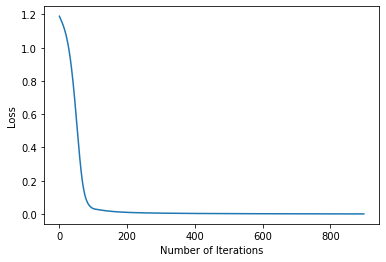

In [ ]:
plt.plot(range(num_epochs),loss_list)
# plt.plot(range(num_epochs),val_loss_list)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
#  loop for the number of epochs, do the forward pass, calculate the loss, improve the weights via the optimizer step.# Train the model

In [ ]:
# # Specify a path
# %pwd
# PATH = "cherat_nn_model2.pt-lr0.001-selectedvariables"

# # # Save
# #torch.save(lstm1, PATH)

# # Load
# model = torch.load(PATH)
# model.eval()

LSTM1(
  (lstm): LSTM(15, 30, batch_first=True)
  (fc_1): Linear(in_features=30, out_features=40, bias=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (silu): SiLU()
)

In [ ]:
# We can now simply perform predictions on the whole dataset via a forward pass, and then to plot them, we will convert the predictions to numpy, reverse transform them (remember that you transformed the labels to check the actual answer, and that we’ll need to reverse transform it) and then plot it.

In [ ]:
test_predict = lstm1.forward(X_test_tensors_final) #forward pass

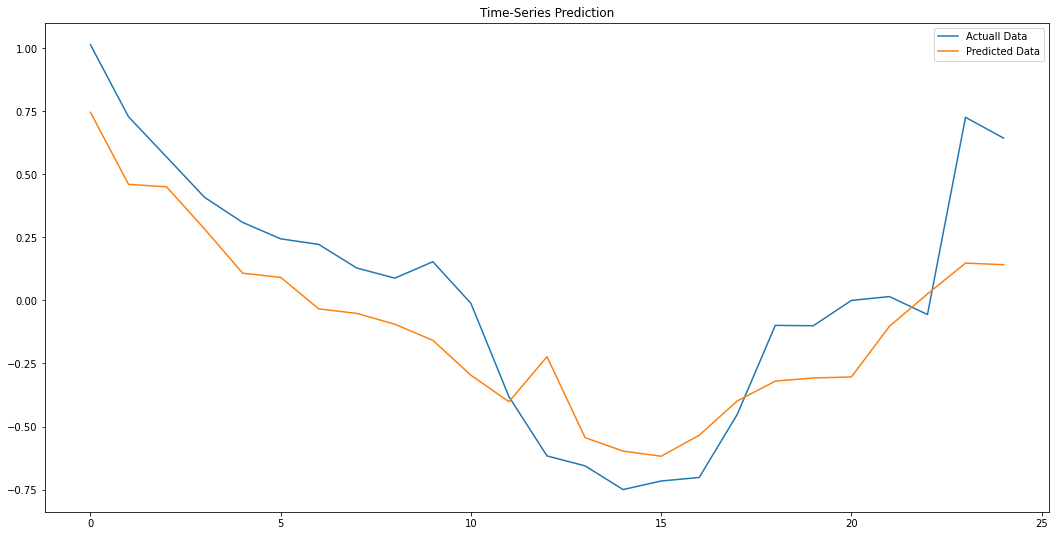

In [ ]:
plt.figure(figsize=(18,9)) #plotting

plt.plot(y_test_tensors.data.numpy(), label='Actuall Data') #actual plot

plt.plot(test_predict.data.numpy(), label='Predicted Data') #predicted plot

plt.title('Time-Series Prediction')

plt.legend()

plt.show() 

# MSE & RMSE

In [ ]:
def mse_rmse(test_variable,prediction_variable):
    a = rmse(test_variable,prediction_variable)
    b = mse(test_variable,prediction_variable)
    print('rmse =', a)
    print('mse =', b)

In [ ]:
mse_rmse(y_test_tensors.data.numpy(),test_predict.data.numpy())

rmse = [0.2503135]
mse = [0.06265685]
